# Import CSV

In [33]:
import pandas as pd
df = pd.read_csv('DSC 288 Processed Reddit Dataset.csv')
print(df)

                                                  Title  \
0     Your anger may be caused by a magnesium defici...   
1     Do you ever get so angry that you wish to kill...   
2     Does anyone else just avoid people because you...   
3     Was anyone else “not allowed” to get upset gro...   
4     I wish people understood that outbursts don't ...   
...                                                 ...   
9073  Fastest way I’ve found to get a panic attack u...   
9074                                 Looking for advice   
9075                        New panic attack experience   
9076  I’m having pretty bad suicidal thoughts, think...   
9077      Anxiety symptoms replicating low blood sugar?   

                                                   Text  Score  Topic  \
0     I tried absolutely everything to fix my chroni...    743  anger   
1     I don't know if it's my anger issues talking o...    692  anger   
2     Lately I’ve been noticing that I take the extr...    489  anger   

# Feature Extraction/Modeling  (Old)

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df['Text_pro'], df['Topic'], test_size=0.2, random_state=2)

In [36]:
#Create Vectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [37]:
#Train Classifier
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [38]:
#Make Predictions
y_pred = clf.predict(X_test)

#Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6321585903083701


In [39]:
#Attempt the same but on the title
X_train, X_test, y_train, y_test = train_test_split(df['Title_pro'], df['Topic'], test_size=0.2, random_state=2)
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6492290748898678


In [40]:
#Now on combined title and text
X_train, X_test, y_train, y_test = train_test_split(df['T_T_pro'], df['Topic'], test_size=0.2, random_state=2)
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6718061674008811


# Optimization

Tuning alpha value. Higher prevents overfitting but may reduce accuracy. GridSearchCV can find the optimal value.

In [41]:
# Following https://sklearner.com/scikit-learn-grid-search-multinomialnb/
from sklearn.model_selection import GridSearchCV

#define a parameter grid
param_grid = {
    'alpha': [0.1, 0.5, 1.0],
    'fit_prior': [True, False]
}

#Continuing with T_T_pro
grid_search = GridSearchCV(estimator=MultinomialNB(),
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy')
grid_search.fit(X_train, y_train)

# Report best score and parameters
print(f"Best score: {grid_search.best_score_:.3f}")
print(f"Best parameters: {grid_search.best_params_}")

# Evaluate on test set
best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print(f"Test set accuracy: {accuracy:.3f}")

Best score: 0.800
Best parameters: {'alpha': 0.1, 'fit_prior': False}
Test set accuracy: 0.813


In [42]:
#Test again
clf = MultinomialNB(alpha=grid_search.best_params_["alpha"], fit_prior=grid_search.best_params_["fit_prior"])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8127753303964758


# Visualizations

In [43]:
#Create a confusion matrix
from sklearn.metrics import confusion_matrix

labels = sorted(list(set(y_test)))

cm = confusion_matrix(y_test, y_pred, labels=labels)

In [44]:
#Calculate error rates by dividing the number of misclassified instances in each label
  #by total number of instances of that label
import numpy as np

erates = {}
for i, label in enumerate(labels):
    total_instances = np.sum(cm[i, :])
    errors = np.sum(cm[i, :]) - cm[i, i]
    err = errors / total_instances if total_instances > 0 else 0
    erates[label] = err

In [45]:
#Display
for label, err in erates.items():
        print(f"Error rate for label {label}: {err:.2f}")

Error rate for label anger: 0.18
Error rate for label anxiety: 0.71
Error rate for label bipolar: 0.20
Error rate for label depression: 0.19
Error rate for label eating disorder: 0.04
Error rate for label panic: 0.07


Text(0.5, 1.0, 'Error Rate Predicting each Label in Decimal')

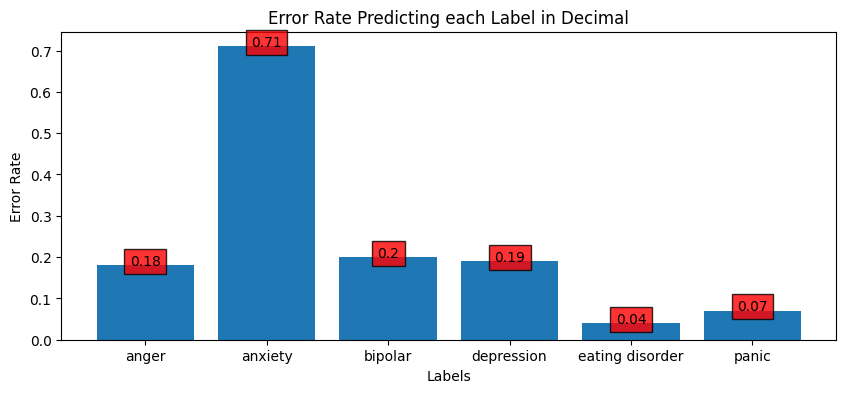

In [46]:
import matplotlib.pyplot as plt

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i], ha='center',
                 bbox = dict(facecolor = 'red', alpha =.8))

labels = list(erates.keys())
errors = [round(num, 2) for num in list(erates.values())]

plt.figure(figsize=(10,4))
plt.bar(labels, errors)
addlabels(labels, errors)
plt.xlabel('Labels')
plt.ylabel('Error Rate')
plt.title('Error Rate Predicting each Label in Decimal')